# The teqp paper in I&ECR 

A few minor changes have been made:
    
* The ``get_splus`` method requires the molar concentrations to be a numpy array (to avoid copies) (as of version 0.14.0
* The top-level methods ``teqp.xxx`` have been deprecated, and the methods attached to the instance are preferred
* The ``radial_dist`` field must always be provided

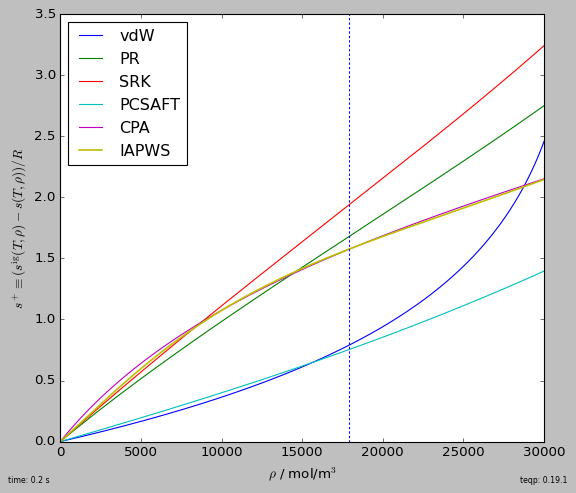

In [1]:
import timeit, numpy as np
import matplotlib.pyplot as plt
plt.style.use('classic')
import teqp

def build_models():
    Tc_K, pc_Pa, acentric = 647.096, 22064000.0, 0.3442920843

    water = {
        "a0i / Pa m^6/mol^2": 0.12277 , "bi / m^3/mol": 0.000014515, "c1": 0.67359, 
        "Tc / K": 647.096, "epsABi / J/mol": 16655.0, "betaABi": 0.0692, "class": "4C"
    }
    j = {"cubic": "SRK", "pures": [water], "R_gas / J/mol/K": 8.3144598, "radial_dist": "CS"}

    datapath = teqp.get_datapath()
    def get_PCSAFT():
        c = teqp.SAFTCoeffs()
        # Values from https://doi.org/10.1016/j.fluid.2017.11.015, 
        # but association contribution is ignored
        c.name = 'Water'
        c.m = 2.5472
        c.sigma_Angstrom = 2.1054
        c.epsilon_over_k = 138.63
        return teqp.PCSAFTEOS(coeffs=[c])
        
    return [
        ('vdW', teqp.vdWEOS([Tc_K], [pc_Pa])),
        ('PR', teqp.canonical_PR([Tc_K], [pc_Pa], [acentric])),
        ('SRK', teqp.canonical_SRK([Tc_K], [pc_Pa], [acentric])),
        ('PCSAFT', get_PCSAFT()),
        ('CPA', teqp.CPAfactory(j)),
        ('IAPWS', teqp.build_multifluid_model(["Water"], datapath))
    ]

fig, ax = plt.subplots(1,1,figsize=(7,6))
T = 700 # K
rhovec = np.geomspace(0.1, 30e3, 10000) # mol/m^3; critical density is 17873.8... mol/m^3
tic = timeit.default_timer()
for abbrv, model in build_models():
    splus = np.array([model.get_splus(T, np.array([rho])) for rho in rhovec])
    plt.plot(rhovec, splus, label=abbrv, lw = 1.5 if abbrv=='IAPWS' else 1)
elap = timeit.default_timer()-tic
plt.axvline(17873.8, dashes=[2,2])
plt.legend(loc='best')
plt.gca().set(xlabel=r'$\rho$ / mol/m$^3$', ylabel=r'$s^+\equiv (s^{\rm ig}(T,\rho)-s(T,\rho))/R$')
plt.tight_layout(pad=0.2)
plt.gcf().text(0,0,f'time: {elap:0.1f} s', ha='left', va='bottom', fontsize=7)
plt.gcf().text(1,0,f'teqp: {teqp.__version__}', ha='right', va='bottom', fontsize=7)
plt.savefig('splus_water_700K.pdf')
plt.show()

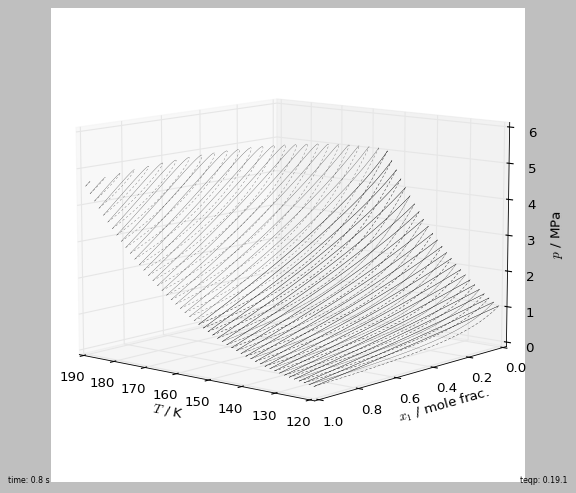

In [2]:
import json, timeit
import pandas, numpy as np, matplotlib.pyplot as plt
plt.style.use('classic')
import teqp

Tc_K = [190.564, 154.581]
pc_Pa = [4599200, 5042800]
acentric = [0.011, 0.022]
model = teqp.canonical_PR(Tc_K, pc_Pa, acentric)
fig, ax = plt.subplots(1,1,figsize=(7, 6), subplot_kw=dict(projection='3d'))
tic = timeit.default_timer()
for ifluid in [0,1]:
    model0 = teqp.canonical_PR([Tc_K[ifluid]], [pc_Pa[ifluid]], [acentric[ifluid]])
    for T in np.linspace(190, 120, 50):
        if T > Tc_K[ifluid]: continue
        [rhoL, rhoV] = model0.superanc_rhoLV(T)
        rhovecL = np.array([0.0, 0.0]); rhovecL[ifluid] = rhoL
        rhovecV = np.array([0.0, 0.0]); rhovecV[ifluid] = rhoV
        opt = teqp.TVLEOptions(); opt.calc_criticality = True
        df = pandas.DataFrame(model.trace_VLE_isotherm_binary(T, rhovecL, rhovecV, opt))
        df['too_critical'] = df.apply(
            lambda row: (abs(row['crit. conditions L'][0]) < 5e-8), axis=1)
        first_too_critical = np.argmax(df['too_critical'])
        df = df.iloc[0:(first_too_critical if first_too_critical else len(df))]
        line, = ax.plot(xs=df['T / K'], ys=df['xL_0 / mole frac.'], zs=df['pL / Pa']/1e6, 
            lw=0.2, color='k')
        ax.plot(xs=df['T / K'], ys=df['xV_0 / mole frac.'], zs=df['pL / Pa']/1e6, 
            dashes=[2,2], color=line.get_color(), lw=0.2)
elap = timeit.default_timer()-tic
ax.view_init(elev=10., azim=130)
ax.set(xlabel='$T$ / K', ylabel='$x_1$ / mole frac.', zlabel='$p$ / MPa')
fig.text(0,0,f'time: {elap:0.1f} s', ha='left', va='bottom', fontsize=7)
fig.text(1,0,f'teqp: {teqp.__version__}', ha='right', va='bottom', fontsize=7)
plt.tight_layout(pad=0.2)
plt.savefig('PR_VLE_trace.pdf')
plt.show()

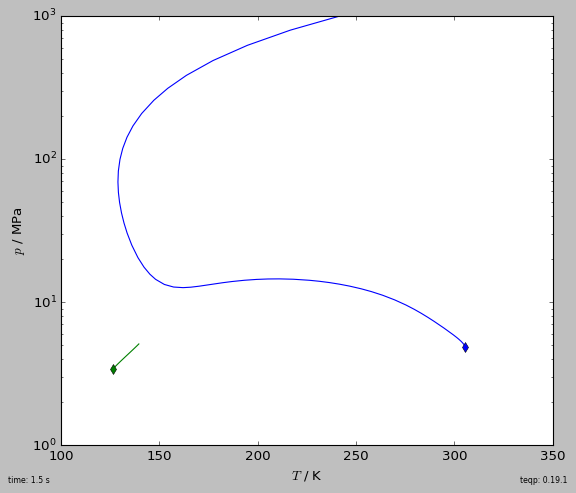

In [3]:
import timeit
import numpy as np
import matplotlib.pyplot as plt 
plt.style.use('classic')
import pandas
import teqp

def get_critical_curve(ipure):
    """ Return curve as pandas DataFrame """
    names = ['Nitrogen', 'Ethane']
    model = teqp.build_multifluid_model(names, teqp.get_datapath())
    T0 = model.get_Tcvec()[ipure]
    rho0 = np.array([1.0/model.get_vcvec()[ipure]]*2)
    rho0[1-ipure] = 0
    o = teqp.TCABOptions() 
    o.init_dt = 1.0 # step in the parameter
    o.rel_err = 1e-8
    o.abs_err = 1e-5
    o.integration_order = 5
    o.calc_stability = True
    o.polish = True
    curveJSON = model.trace_critical_arclength_binary(T0, rho0, '', o)
    df = pandas.DataFrame(curveJSON)
    rhotot = df['rho0 / mol/m^3']+df['rho1 / mol/m^3']
    df['z0 / mole frac.'] = df['rho0 / mol/m^3']/rhotot
    return df

if __name__ == '__main__':
    fig, ax = plt.subplots(1,1,figsize=(7, 6))
    tic = timeit.default_timer()
    for ipure in [1,0]:
        df = get_critical_curve(ipure)
        first_unstable = np.argmax(~df['locally stable'])
        df = df.iloc[0:(first_unstable if first_unstable else len(df))]
        line, = plt.plot(df['T / K'], df['p / Pa']/1e6, '-')
        plt.plot(df['T / K'].iloc[0], df['p / Pa'].iloc[0]/1e6, 'd', 
            color=line.get_color())

    elap = timeit.default_timer()-tic
    plt.gca().set(xlabel='$T$ / K', ylabel='$p$ / MPa',
        xlim=(100, 350), ylim=(1, 1e3))
    plt.yscale('log')
    plt.tight_layout(pad=0.2)
    plt.gcf().text(0,0,f'time: {elap:0.1f} s', ha='left', va='bottom', fontsize=7)
    plt.gcf().text(1,0,f'teqp: {teqp.__version__}', ha='right', va='bottom', fontsize=7)
    plt.savefig('N2_ethane_critical.pdf')
    plt.show()